In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import pickle
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [44]:
def get_data(path):
    data = pd.read_csv(path,names = ['label','document'])
    return data

In [45]:
data = get_data('D:\\cs\\Heavywater\\document-classification-test-master\\shuffled-full-set-hashed.csv')

In [46]:
data.columns.values
data.info()
data['document'].isnull().sum()
data = data.dropna().reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62204 entries, 0 to 62203
Data columns (total 2 columns):
label       62204 non-null object
document    62159 non-null object
dtypes: object(2)
memory usage: 972.0+ KB


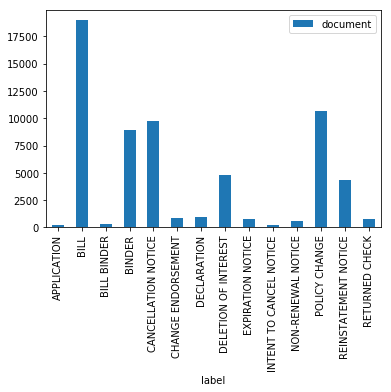

In [5]:
fig = plt.figure()
data.groupby(['label']).count().plot.bar(ylim=0)
plt.show()

In [6]:
#Training Initial models using CountVectorizer
count_vect = CountVectorizer()
X_train_count = count_vect.fit_transform(data['document'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_train_count, data['label'], random_state = 10,test_size=0.25)

In [8]:
clf = MultinomialNB(alpha = 1e-4).fit(X_train, y_train)
print(clf.score(X_test,y_test))

0.76537966538


In [9]:
clf = LinearSVC(C = 0.5,penalty='l1',dual=False).fit(X_train, y_train)
print(clf.score(X_test,y_test))

0.859845559846


In [10]:
clf = LogisticRegression().fit(X_train, y_train)
print(clf.score(X_test,y_test))

0.868854568855


In [6]:
#Training models using Tf-Idf feature transformation
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=0.01, norm='l1', ngram_range=(1, 3), stop_words='english')
features = tfidf.fit_transform(data.document).toarray()
labels = data.label
print(features.shape)

(62159, 3948)


In [7]:
X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(features)
print(X_reduced.shape)

(62159, 50)


In [8]:
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced[:10000])

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.007364
[t-SNE] Iteration 25: error = 1.2680863, gradient norm = 0.0011133
[t-SNE] Iteration 50: error = 1.2656180, gradient norm = 0.0089418
[t-SNE] Iteration 75: error = 1.1852647, gradient norm = 0.0029205
[t-SNE] Iteratio

In [10]:
ids, levels = pd.factorize(labels)
data = pd.DataFrame(X_embedded)
ids = pd.Series(ids[:20000])
data = pd.concat([data,ids],axis=1)
data.columns = ['x','y','label']

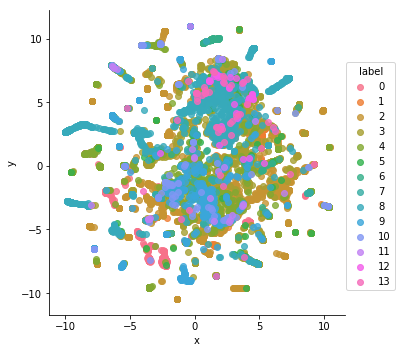

In [12]:
sns.lmplot(x='x',y='y',data=data,fit_reg=False,hue='label',legend=True)

In [25]:
#Checking which model would be the best for the training set
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state = 10,test_size=0.25)

In [26]:
clf = RandomForestClassifier(n_estimators=500, random_state=0).fit(X_train, y_train)
print(clf.score(X_test,y_test))

0.866409266409


In [27]:
clf = LinearSVC(max_iter=2000).fit(X_train, y_train)
print(clf.score(X_test,y_test))

0.816023166023


In [28]:
clf = LogisticRegression(random_state=0,max_iter=2000).fit(X_train, y_train)
print(clf.score(X_test,y_test))

0.679086229086


In [29]:
clf = MultinomialNB(alpha = 1e-3).fit(X_train, y_train)
print(clf.score(X_test,y_test))

0.557528957529


In [31]:
clf = LinearSVC(max_iter=2000).fit(features, labels)
print(clf.score(features,labels))

0.830338325906


In [20]:
clf = RandomForestClassifier(n_estimators=500, random_state=0).fit(features, labels)
print(clf.score(features,labels))
y_pred = clf.predict(features)

0.994063611062


In [25]:
# save the model to disk
filename = 'model.pkl'
pickle.dump(clf, open(filename, 'wb'))

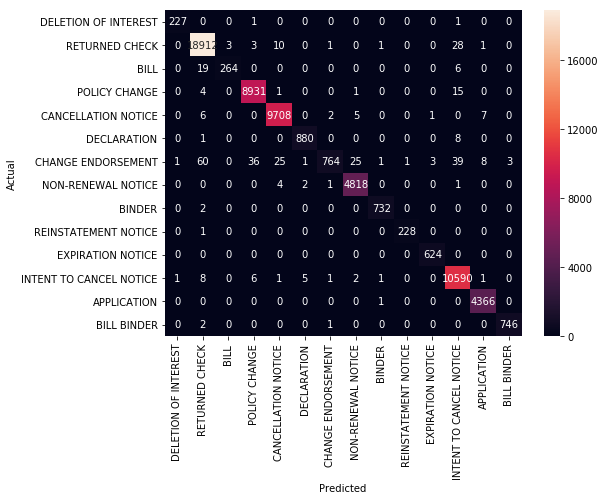

In [41]:
conf_mat = confusion_matrix(labels.values, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels.unique(), yticklabels=labels.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()